### Importing required libraries

In [1]:
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset, Dataset, concatenate_datasets

d:\ML_Practice\LLAMA_FineTuning\finetune\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    logging,
)

In [3]:
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
)

In [4]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import nlpaug.augmenter.word as naw

In [5]:
# Model and tokenizer configuration
model_name = "meta-llama/Llama-3.2-1B"
output_dir = "./llama-3.2-banking77-lora-finetuned_10052025"

In [6]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [7]:
# Load Banking77 dataset
dataset = load_dataset("legacy-datasets/banking77")
print(f"Dataset loaded: {dataset}")

Using the latest cached version of the dataset since legacy-datasets/banking77 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\dtsat\.cache\huggingface\datasets\legacy-datasets___banking77\default\0.0.0\f54121560de48f2852f90be299010d1d6dc612ec (last modified on Tue Apr  1 17:17:43 2025).


Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [8]:
# Analyze class distribution in the dataset
intent_counts = Counter(dataset["train"]["label"])

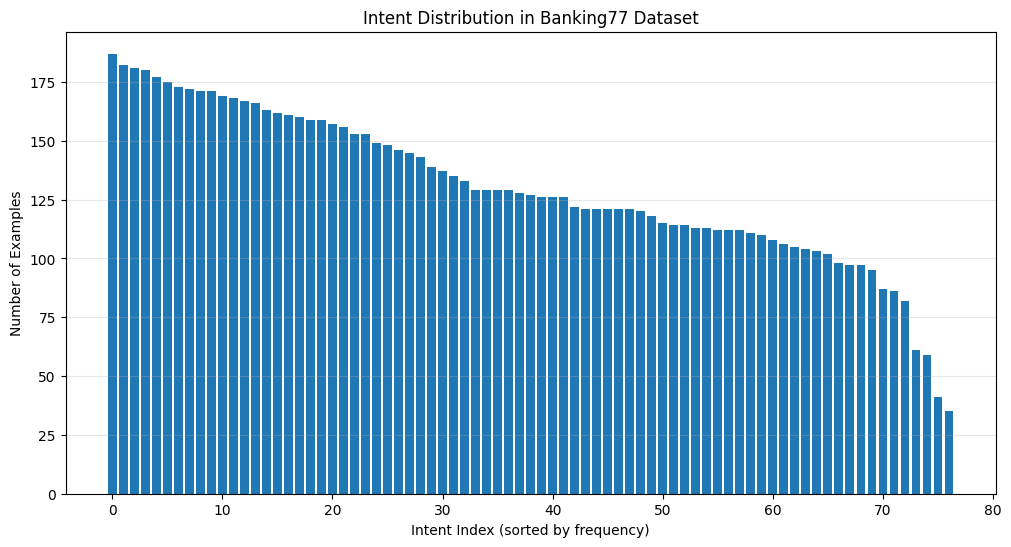

In [9]:
# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(intent_counts)), sorted(intent_counts.values(), reverse=True))
plt.xlabel('Intent Index (sorted by frequency)')
plt.ylabel('Number of Examples')
plt.title('Intent Distribution in Banking77 Dataset')
plt.grid(axis='y', alpha=0.3)
plt.savefig('intent_distribution.png')
plt.show()
plt.close()

In [10]:
print("Most common intents:", intent_counts.most_common(5))
print("Least common intents:", intent_counts.most_common()[:-6:-1])

Most common intents: [(15, 187), (28, 182), (6, 181), (75, 180), (19, 177)]
Least common intents: [(23, 35), (72, 41), (10, 59), (18, 61), (41, 82)]


In [11]:
# Select 5 random intents to hold out for few-shot evaluation
all_intents = list(set(dataset["train"]["label"]))
print(f"Total number of intents: {len(all_intents)}")

# Select 5 random intents to exclude from training
excluded_intents = random.sample(all_intents, 5)
print(f"Excluded intents: {excluded_intents}")

Total number of intents: 77
Excluded intents: [14, 3, 35, 31, 28]


In [12]:
# Define label mapping
label_descriptions = {}
for i in range(77):
    # In a real scenario, you would have actual label descriptions
    label_descriptions[i] = f"Category {i}"

In [13]:
# Filter the dataset to create training and few-shot datasets
def filter_dataset(dataset_split, excluded_intents, include_excluded=False):
    """
    Filter dataset to either include or exclude specific intents
    """
    filtered_indices = []
    for i, label in enumerate(dataset_split["label"]):
        if (label in excluded_intents) == include_excluded:
            filtered_indices.append(i)
    
    return dataset_split.select(filtered_indices)

In [14]:
# Create datasets - one for training (72 intents) and one for few-shot examples (5 intents)
train_dataset = filter_dataset(dataset["train"], excluded_intents, include_excluded=False)
eval_dataset = filter_dataset(dataset["test"], excluded_intents, include_excluded=False)
few_shot_dataset = filter_dataset(dataset["train"], excluded_intents, include_excluded=True)

In [15]:
print(f"Training examples: {len(train_dataset)}")
print(f"Evaluation examples: {len(eval_dataset)}")
print(f"Few-shot examples: {len(few_shot_dataset)}")

Training examples: 9364
Evaluation examples: 2880
Few-shot examples: 639


In [16]:
def augment_text_example(text, intent, num_augmentations=2):
    """Generate augmented examples for a given text and intent"""
    augmented_examples = []
    # Word replacement augmenter (synonym replacement)
    aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_max=2)
    # Random word swap augmenter
    aug_swap = naw.RandomWordAug(action="swap", aug_max=2)
    # Context-based word insertion augmenter
    try:
        aug_insert = naw.ContextualWordEmbsAug(
            model_path='distilbert-base-uncased', action='insert', aug_max=2
        )
        augmenters = [aug_synonym, aug_swap, aug_insert]
    except:
        # Fallback if contextual augmenter can't be loaded
        augmenters = [aug_synonym, aug_swap]
    
    # Generate augmentations
    for i in range(min(num_augmentations, len(augmenters))):
        aug = augmenters[i]
        try:
            augmented_text = aug.augment(text)
            if isinstance(augmented_text, list):
                augmented_text = augmented_text[0]
            augmented_examples.append({"text": augmented_text, "label": intent})
        except Exception as e:
            print(f"Augmentation error: {e}")
            continue
    
    return augmented_examples


In [17]:
# Count examples per intent in the filtered training set
filtered_intent_counts = Counter(train_dataset["label"])

In [18]:
# Identify minority classes that need augmentation
intent_threshold = np.median(list(filtered_intent_counts.values()))  # Use median as threshold
print(f"Augmentation threshold: {intent_threshold} examples")

Augmentation threshold: 127.5 examples


In [19]:
import nltk
from nltk import *
from nltk.corpus import wordnet

In [ ]:
# Apply augmentation to minority classes
augmented_examples = []
for intent, count in filtered_intent_counts.items():
    if count < intent_threshold:
        # Get examples for this intent
        intent_examples = [ex for i, ex in enumerate(train_dataset) if ex["label"] == intent]
        
        # Determine how many augmentations needed per example
        aug_factor = min(3, max(1, int(intent_threshold / max(1, count))))
        
        # Augment each example
        for example in intent_examples:
            new_examples = augment_text_example(
                example["text"], example["label"], num_augmentations=aug_factor
            )
            augmented_examples.extend(new_examples)

print(f"Generated {len(augmented_examples)} augmented examples")

In [23]:
# Create a dataset from augmented examples
import pandas as pd
if len(augmented_examples) > 0:
    original_features = train_dataset.features
    augmented_dataset = Dataset.from_pandas(
        pd.DataFrame({
        "text": [ex["text"] for ex in augmented_examples],
        "label": [ex["label"] for ex in augmented_examples]
    }),
    features = original_features
    )
    
    # Combine with original training data
    train_dataset = concatenate_datasets([train_dataset, augmented_dataset])
    print(f"Training dataset size after augmentation: {len(train_dataset)}")

Training dataset size after augmentation: 9560


In [ ]:
# Apply augmentation to minority classes
augmented_examples = []
for intent, count in filtered_intent_counts.items():
    if count < intent_threshold:
        # Get examples for this intent
        intent_examples = [ex for i, ex in enumerate(train_dataset) if ex["label"] == intent]
        
        # Determine how many augmentations needed per example
        aug_factor = min(3, max(1, int(intent_threshold / max(1, count))))
        
        # Augment each example
        for example in intent_examples:
            new_examples = augment_text_example(
                example["text"], example["label"], num_augmentations=aug_factor
            )
            augmented_examples.extend(new_examples)

print(f"Generated {len(augmented_examples)} augmented examples")

In [24]:
augmented_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 196
})

In [25]:
# Create a small set of few-shot examples (3 per intent)
few_shot_examples = []
for intent in excluded_intents:
    # Get examples for this intent
    intent_examples = [ex for i, ex in enumerate(few_shot_dataset) if ex["label"] == intent]
    # Select up to 3 examples
    selected = intent_examples[:3] if len(intent_examples) >= 3 else intent_examples
    few_shot_examples.extend(selected)

print(f"Number of few-shot examples selected: {len(few_shot_examples)}")

Number of few-shot examples selected: 15


In [26]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
# Function to preprocess the dataset - do NOT convert to tensors here
def preprocess_function(examples):
    formatted_inputs = []
    
    for text, label_id in zip(examples["text"], examples["label"]):
        # Get the label description
        label_text = label_descriptions[label_id]
        
        # Create input prompt
        prompt = f"### Instruction: Classify the following bank customer query into the appropriate category.\n\n### Input: {text}\n\n### Response: {label_text}"
        formatted_inputs.append(prompt)

    tokenized_inputs = tokenizer(
        formatted_inputs,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors=None  # Don't convert to tensors yet
    )
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs


In [28]:
# Apply preprocessing to the dataset
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["text", "label"]
)

Map: 100%|██████████| 9560/9560 [00:02<00:00, 3502.69 examples/s]


In [29]:
tokenized_eval = eval_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["text", "label"]
)

Map: 100%|██████████| 2880/2880 [00:01<00:00, 2156.54 examples/s]


In [ ]:
# Load the model in standard precision for LoRA
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    r=16,               # rank dimension
    lora_alpha=32,      # scaling factor
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # attention layers to fine-tune
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [ ]:
# Apply LoRA
model = get_peft_model(model, lora_config)
print(f"Model loaded with LoRA configuration: {model}")

In [ ]:
# Print trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params} ({100 * trainable_params / all_params:.2f}% of all params)")

print_trainable_parameters(model)


In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_dataset["label"]),
    y=train_dataset["label"]
)

In [ ]:
# Convert to dictionary for easier lookup
weight_dict = {i: float(weight) for i, weight in enumerate(class_weights) if i in np.unique(train_dataset["label"])}

print("Class weights (first 5):", {i: weight_dict[i] for i in list(weight_dict.keys())[:5]})

# Create a weighted sampler for the DataLoader
class_weight_tensor = torch.tensor([weight_dict.get(label, 1.0) for label in train_dataset["label"]], dtype=torch.float)

In [ ]:
# Use a data collator that handles padding and conversion to tensors at batch time
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # we're doing causal language modeling not masked language modeling
    return_tensors="pt"
)

In [ ]:
# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Find the indices where labels are not -100 (padding token)
    mask = labels != -100
    
    # Get predictions
    predictions = logits.argmax(axis=-1)
    
    # Filter out padding tokens
    filtered_predictions = []
    filtered_labels = []
    
    for i in range(len(predictions)):
        pred = predictions[i][mask[i]]
        label = labels[i][mask[i]]
        
        if len(pred) > 0 and len(label) > 0:
            # Use the last few tokens (where the response should be)
            # This is a very simplified approach and may need refinement
            filtered_predictions.append(pred[-1])  # Just using the last token
            filtered_labels.append(label[-1])
    
    # Compute metrics
    accuracy = accuracy_score(filtered_labels, filtered_predictions)
    
    # F1 score may not be applicable for single token prediction
    # This is just a placeholder
    try:
        f1 = f1_score(filtered_labels, filtered_predictions, average='weighted')
    except:
        f1 = 0.0
    
    return {
        "accuracy": accuracy,
        "f1": f1
    }


In [ ]:
# Training arguments (adjusted for standard LoRA)
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=200,
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    report_to="none"
)


In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
# Save the fine-tuned model
trainer.save_model(output_dir)

### Inference

In [2]:
base_model_name = "meta-llama/Llama-3.2-1B"
lora_adapter_path = "./llama-3.2-lora-finetuned"

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

In [1]:
from peft import PeftModel

In [ ]:
model = PeftModel.from_pretrained(base_model, lora_adapter_path)

tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [3]:
# Create a prediction pipeline
def predict_category(text):
    # Format input just like during training
    prompt = f"### Instruction: Classify the following bank customer query into the appropriate category.\n\n### Input: {text}\n\n### Response:"
    
    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        # Generate prediction
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.1,
        )
    
    # Decode the prediction
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the actual response part (after "### Response:")
    try:
        response = decoded_output.split("### Response:")[1].strip()
    except:
        response = decoded_output
    
    return response

In [4]:
correct = 0
total = 0

text_list = []
actual_category_list = []
predicted_category_list = []

In [ ]:
for i, example in enumerate(eval_dataset):
    text = example["text"]
    text_list.append(text)
    
    actual_category = label_description[example["label"]]
    actual_category_list.append(actual_category)
    
    # Get model prediction
    predicted_category = predict_category(text)
    predicted_category_list.append(predicted_category)
    
    # Count correct predictions
    if predicted_category.strip() == actual_category.strip():
        correct += 1
    total += 1

In [ ]:
import pandas as pd
df = pd.DataFrame({"Text":text_list, "Actual_Category":actual_category_list, "Predicted_category":predicted_category_list})

In [ ]:
import re

def extract_category(text):
    match = re.search(r'Category\s+(\d+\s*:?)', text)  # Match "Category xx" with 1 or 2 digits
    if match:
        category_match = match.group(1)
        category_clean = category_match.rstrip(": ")
        return f"Category {category_clean}"
    else:
        return None  # Return None if no match

# Create new column with extracted category
df['Final_Category'] = df['Predicted_Category'].apply(extract_category)

# Display result
df.head()

In [ ]:
matches = df["Actual_Category"]==df["Final_Category"]
accuracy = matches.mean()*100

total_records = len(df)
matching_records = matches.sum()

print(f"Matching records: {matching_records} out of {total_records}")
print(f"Accuracy: {accuracy:.2f}%")

In [ ]:
df.to_csv("FinalOutput.csv", index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Compute accuracy
accuracy = accuracy_score(df["Actual_Category"], df["Final_Category"])

# Compute precision, recall, and F1-score for each category
precision, recall, f1, _ = precision_recall_fscore_support(df["Actual_Category"], df["Final_Category"], average=None)

# Compute weighted precision and recall
weighted_precision, weighted_recall, _, _ = precision_recall_fscore_support(
    df["Actual_Category"], df["Final_Category"], average="weighted"
)

# Print results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Precision for each category:", dict(zip(sorted(df["Actual_Category"].unique()), precision)))
print("Recall for each category:", dict(zip(sorted(df["Actual_Category"].unique()), recall)))
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")

In [ ]:
category_match_counts = df[df["Actual_Category"] == df["Final_Category"]].groupby("Actual_Category").size()
final_df = df.copy()
actual_counts = final_df["Actual_Category"].value_counts().rename("Actual_Counts")
predicted_counts = final_df["Final_Category"].value_counts().rename("Predicted_Counts")

In [ ]:
match_counts = final_df[final_df["Actual_Category"] == final_df["Final_Category"]]["Actual_Category"].value_counts().rename("Match_Count")

result_df = pd.DataFrame({'Category':actual_counts.index})
result_df = result_df.set_index('Category')
result_df = result_df.join(actual_counts).join(predicted_counts).join(match_counts, how='left').fillna(0)

In [ ]:
result_df["%Match"] = (result_df["Match_Count"]/result_df["Actual_Counts"])*100

result_df = result_df.reset_index()


In [ ]:
result_df.head()

result_df[result_df["%Match"]<70]

In [ ]:
# Create a few-shot prompt for inference with examples of the excluded intents
def create_few_shot_prompt(query, few_shot_examples):
    # Create the few-shot prompt with 3 examples per excluded intent
    prompt = "### Instruction: Classify the following bank customer query into the appropriate category.\n\n"
    
    # Add few-shot examples
    for example in few_shot_examples:
        text = example["text"]
        label = example["label"]
        label_text = label_descriptions[label]
        prompt += f"### Input: {text}\n\n### Response: {label_text}\n\n"
    
    # Add the query
    prompt += f"### Input: {query}\n\n### Response:"
    
    return prompt


In [ ]:
# Function for inference with few-shot examples
def generate_answer_with_few_shot(query, model, tokenizer, few_shot_examples):
    # Create few-shot prompt
    prompt = create_few_shot_prompt(query, few_shot_examples)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract just the response part
    response = response.split("### Response:")[-1].strip()
    return response



In [ ]:
# Define regular inference function for comparison
def generate_answer(query, model, tokenizer):
    prompt = f"### Instruction: Classify the following bank customer query into the appropriate category.\n\n### Input: {query}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract just the response part
    response = response.split("### Response:")[-1].strip()
    return response


In [ ]:
# Get a test query from the excluded intents
test_examples_for_excluded = filter_dataset(dataset["test"], excluded_intents, include_excluded=True)
if len(test_examples_for_excluded) > 0:
    test_example = test_examples_for_excluded[0]
    sample_query = test_example["text"]
    true_label = label_descriptions[test_example["label"]]
    
    # Test with regular inference (no few-shot)
    result_no_few_shot = generate_answer(sample_query, model, tokenizer)
    
    # Test with few-shot inference
    result_few_shot = generate_answer_with_few_shot(sample_query, model, tokenizer, few_shot_examples)
    
    print(f"Sample Query: {sample_query}")
    print(f"True Label: {true_label}")
    print(f"Predicted (No Few-Shot): {result_no_few_shot}")
    print(f"Predicted (With Few-Shot): {result_few_shot}")
else:
    print("No test examples found for excluded intents!")
